# Introduction 
In this tutorial, we demonstrate how to use Monocle 2 to resolve the complicated haematopoiesis process which involves two major branch points (HSC bifurcates into either megakaryote/erythroid progenitor (MEP) or granulocyte/monocyte progenitor (GMP) and the bifurcation from GMP into either granulocyte and monocyte progenitor) by applying reversed graph embedding (RGE). The reconstructed developmental trajectory is learned in four dimensions but can be visualized in two dimensions. With the trajectory learned we are able to identify genes showing significant bifurcation pattern during each lineage bifurcation through BEAM (\cite{}). We can furhter combine ChIP-seq datasets for Gfi1 (granulocyte master regulator) and Irf8 (monocyte master regulator) as well as the transcription factors to build a regulatory network from master regulators to other important downstream regulators and then those regulators to their downstream targets. This network hiearchy is promising to resolve the fundamental regulatory mechanism for the haematopoiesis. We also provided multi-way heatmap / kinetic curves to visualize important marker genes over the differentiation process. Some additional analysis are included, which are used for the tutorial on analyzing the Paul dataset.   

# preparing the data 


In [1]:
rm(list = ls()) # clear the environment 

# helper function to set the root state correctly 
get_correct_root_state <- function(cds){
  T0_counts <- table(pData(cds)$State, pData(cds)$Type)[,"Lsk"]
  as.numeric(names(T0_counts)[which(T0_counts == max(T0_counts))])
}

####################################################################################################################################################################################
#load all package
####################################################################################################################################################################################
suppressMessages(library(monocle))
suppressMessages(library(stringr))
suppressMessages(library(xacHelper))
suppressMessages(library(plyr))
# source all necessary helper function 

Warning message:
“replacing previous import ‘dplyr::union’ by ‘igraph::union’ when loading ‘monocle’”Warning message:
“replacing previous import ‘dplyr::as_data_frame’ by ‘igraph::as_data_frame’ when loading ‘monocle’”Warning message:
“replacing previous import ‘dplyr::groups’ by ‘igraph::groups’ when loading ‘monocle’”Warning message:
“replacing previous import ‘dplyr::%>%’ by ‘igraph::%>%’ when loading ‘monocle’”Warning message:
“replacing previous import ‘dplyr::arrange’ by ‘plyr::arrange’ when loading ‘monocle’”

# prepare the cds for both of the full dataset

In [2]:
#reading the exprs data and create a cell dataset:
# source('/Users/xqiu/Dropbox (Personal)/Projects/DDRTree_fstree/DDRTree_fstree/scripts/nature_hta_analysis_tmp.R')
hta_exprs <- read.csv("/Users/xqiu/Dropbox (Personal)/Projects/DDRTree_fstree/DDRTree_fstree/Nature_hta_paper_Monocle_run_archive/input/Olsson_RSEM_SingleCellRNASeq.csv",row.names=1)
sample_sheet <- data.frame(groups = str_split_fixed(colnames(hta_exprs), "\\.+", 3), row.names = colnames(hta_exprs))
gene_ann <- data.frame(gene_short_name = row.names(hta_exprs), row.names = row.names(hta_exprs))
pd <- new("AnnotatedDataFrame",data=sample_sheet)
fd <- new("AnnotatedDataFrame",data=gene_ann)

tpm_mat <- hta_exprs
tpm_mat <- apply(tpm_mat, 2, function(x) x / sum(x) * 1e6)

URMM_all_std <- newCellDataSet(as.matrix(tpm_mat),phenoData = pd,featureData =fd,
                           expressionFamily = negbinomial.size(),
                           lowerDetectionLimit=1)

#set up the experimental type for each cell
pData(URMM_all_std)[, 'Type'] <- as.character(pData(URMM_all_std)[, 'groups.1']) #WT cells
pData(URMM_all_std)[453:593, 'Type'] <- paste(as.character(pData(URMM_all_std)[453:593, 'groups.1']), '_knockout', sep = '') #KO cells
pData(URMM_all_std)[594:640, 'Type'] <- paste(pData(URMM_all_std)[594:640, 'groups.1'], pData(URMM_all_std)[594:640, 'groups.2'], 'knockout', sep = '_') #double KO cells

#run Census to get the transcript counts
URMM_all_abs_list <- relative2abs(URMM_all_std, t_estimate = estimate_t(URMM_all_std), return_all = T, method = 'num_genes')
URMM_all_abs <- newCellDataSet(as.matrix(URMM_all_abs_list$norm_cds),
                               phenoData = new("AnnotatedDataFrame",data=pData(URMM_all_std)),
                               featureData = new("AnnotatedDataFrame",data=fData(URMM_all_std)),
                               expressionFamily = negbinomial.size(),
                               lowerDetectionLimit=1)
URMM_all_abs <- estimateSizeFactors(URMM_all_abs)
suppressMessages(URMM_all_abs <- estimateDispersions(URMM_all_abs)) # suppress the warning produced from glm fit 

URMM_all_abs <- setOrderingFilter(URMM_all_abs, row.names(fData(URMM_all_abs)))

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in parametricDispersionFit(disp_table, verbose):
“Dispersion fit did not converge.”

# prepare the cds for both of the WT dataset

In [3]:
#########################################################################################################################################################################
#read data from figure 1b
fig1b <- read.csv("/Users/xqiu/Dropbox (Personal)/Projects/DDRTree_fstree/DDRTree_fstree/Nature_hta_paper_Monocle_run_archive/input/fig1b.txt",row.names=1, sep = '\t')

#match up the column name in fig1b to the colnames in URMM_all_fig1b
#note that you should not run this mutliple times
URMM_all_fig1b <- URMM_all_abs[, pData(URMM_all_abs)$Type %in% c('Lsk', 'Cmp', 'Gmp', 'LK')]

fig1b_names <- colnames(fig1b)
match_id <- which(str_split_fixed(colnames(fig1b), "\\.+", 2)[, 2] %in% colnames(URMM_all_fig1b) == T)
fig1b_names[match_id] <- str_split_fixed(colnames(fig1b), "\\.+", 2)[match_id, 2]
no_match_id <- which(str_split_fixed(colnames(fig1b), "\\.+", 2)[, 2] %in% colnames(URMM_all_fig1b) == F)
fig1b_names[no_match_id] <- str_split_fixed(colnames(fig1b), "\\.\\.", 2)[no_match_id, 2]
colnames(fig1b)[2:383] <- fig1b_names[2:383]

#set up the color for each experiment
cols <- c("Lsk" = "#edf8fb", "Cmp" = "#ccece6", "Gmp" = "#99d8c9", "GG1" = "#66c2a4", "IG2" = "#41ae76", "Irf8" = "#238b45", "LK" = "#005824",
          "Irf8_knockout" = "#fc8d59", "Gfi1_Irf8_knockout" = "#636363", "Gfi1_knockout" = "#dd1c77")

#########################################################################################################################################################################
#assign clusters to each cell based on the clustering in the original study
pData(URMM_all_fig1b)$cluster <- 0
cluster_assignments <- as.numeric(fig1b[1, 2:383])
cluster_assignments <- revalue(as.factor(cluster_assignments), c("1" = "HSCP-1", "2" = "HSCP-2", "3" = "Meg", "4" = "Eryth",
                                                                 "5" = "Multi-Lin", "6" = "MDP", "7" = "Mono", "8" = "Gran", "9" = "Myelocyte"))

names(cluster_assignments) <- colnames(fig1b[1, 2:383])
pData(URMM_all_fig1b)$cluster <- cluster_assignments[row.names(pData(URMM_all_fig1b))]
#########################################################################################################################################################################
URMM_all_fig1b <- estimateSizeFactors(URMM_all_fig1b)
suppressMessages(URMM_all_fig1b <- estimateDispersions(URMM_all_fig1b))

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in parametricDispersionFit(disp_table, verbose):
“Dispersion fit did not converge.”

# running dpFeature by using the cluster genes from the original paper

Warning message in if (method == "DDRTree") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (method == "densityPeak") {:
“the condition has length > 1 and only the first element will be used”

Distance cutoff calculated to 1.588421 


the length of the distance: 72771


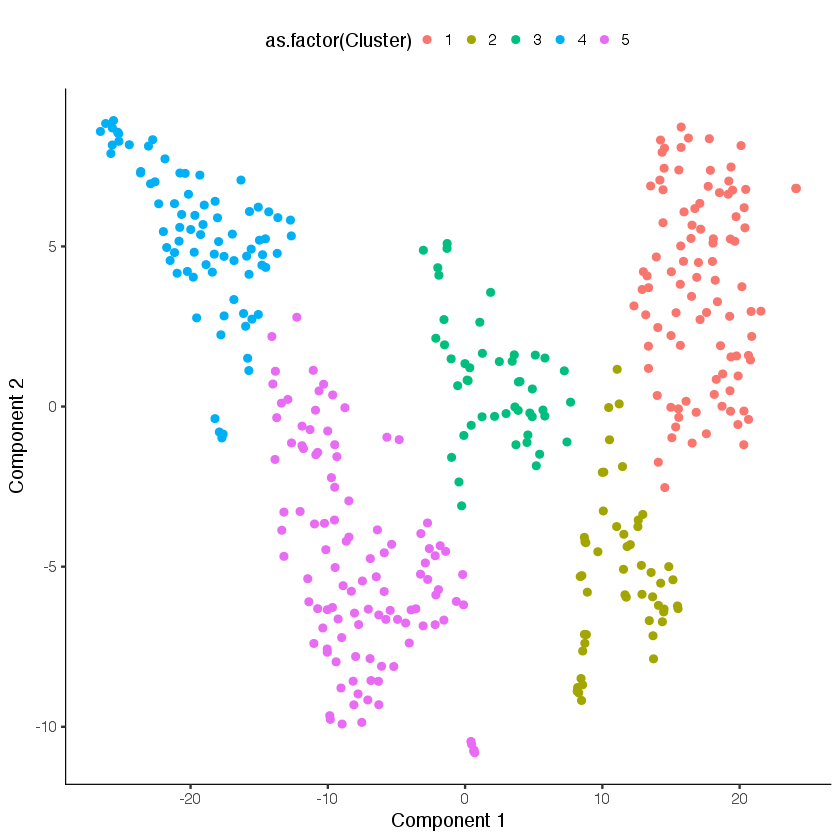

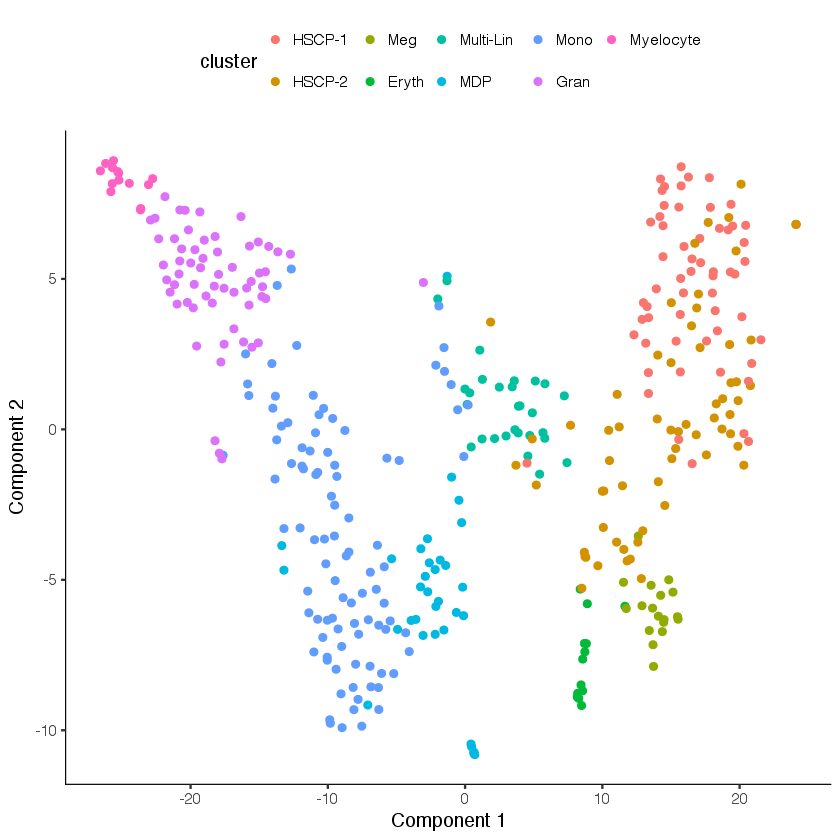

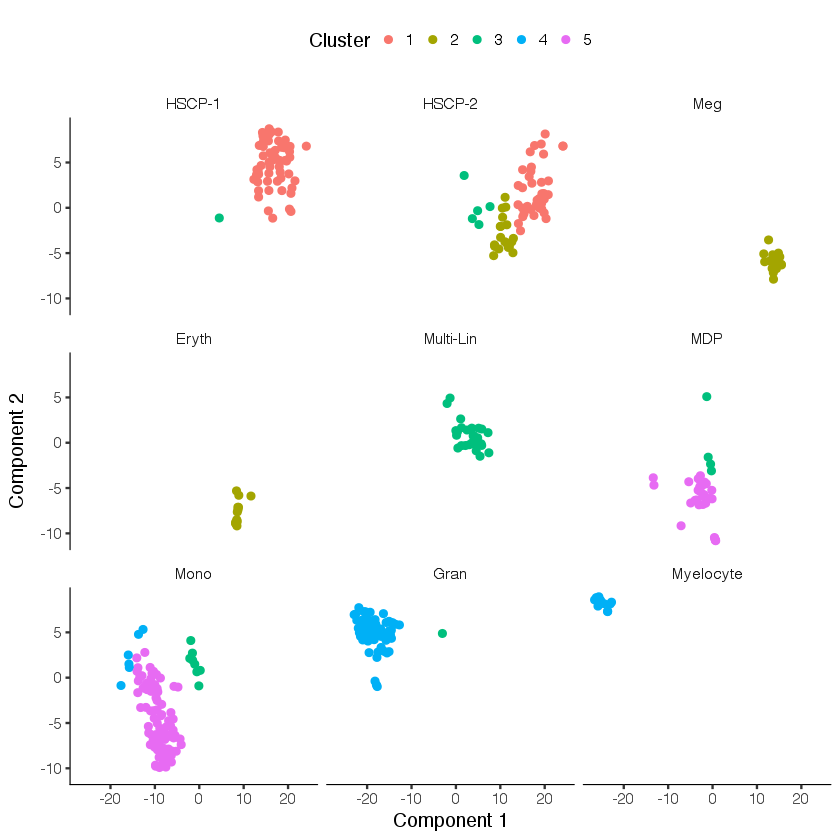

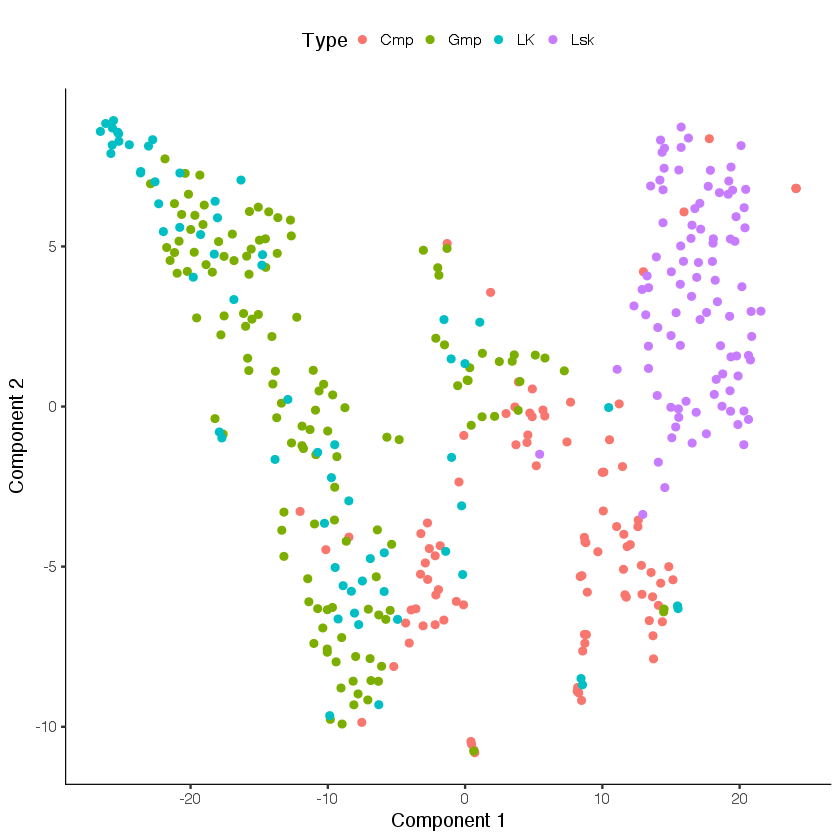

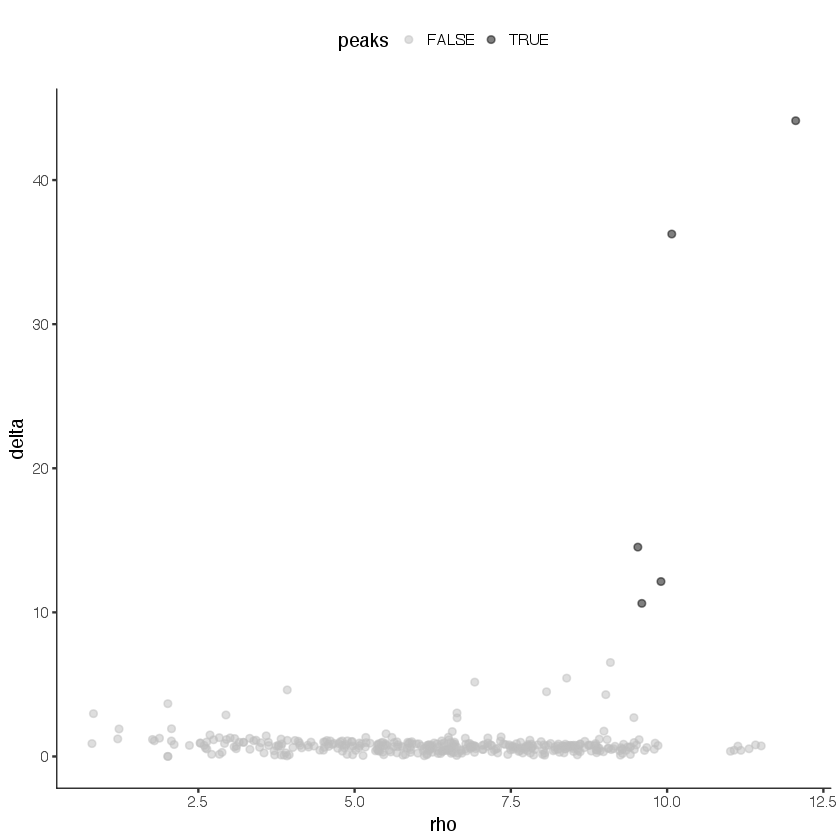

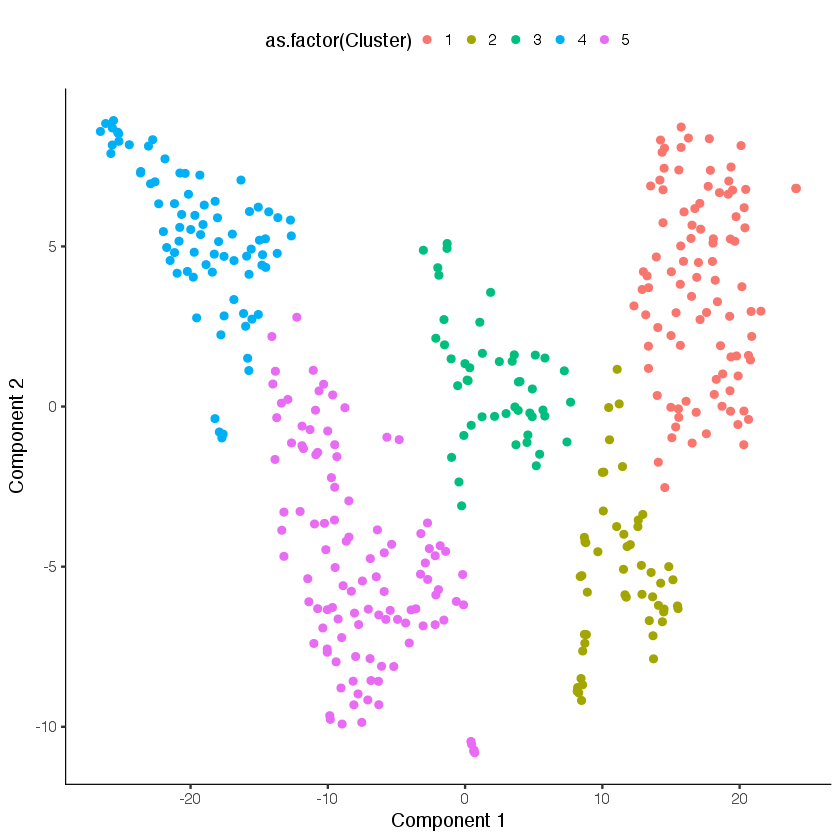

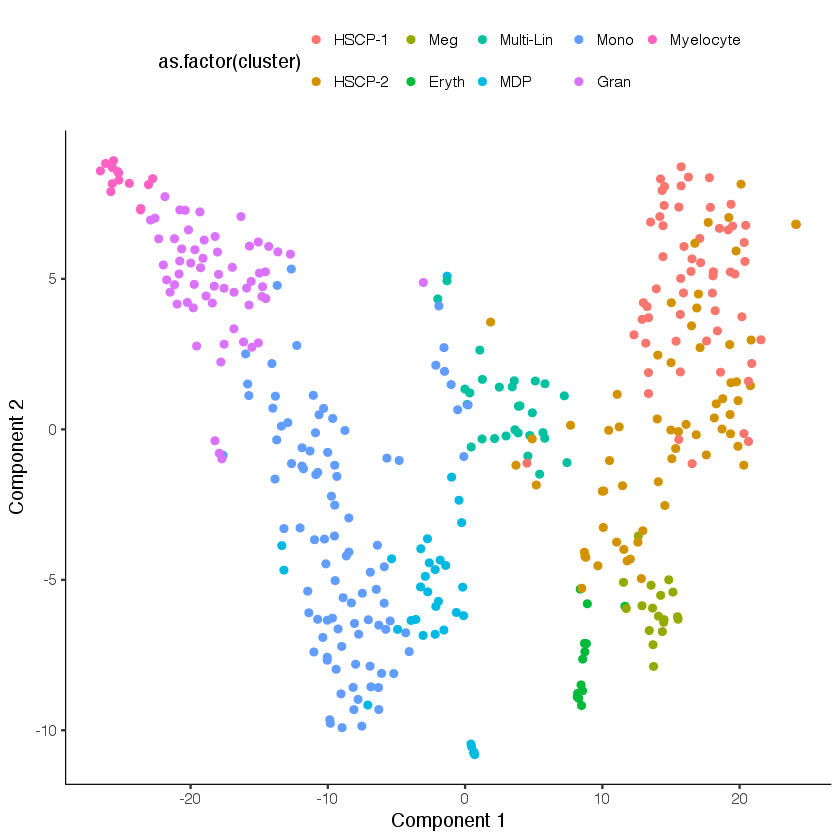

Warning message:
“closing unused connection 9 (<-localhost:11748)”Warning message:
“closing unused connection 8 (<-localhost:11748)”Warning message:
“closing unused connection 7 (<-localhost:11748)”Warning message:
“closing unused connection 6 (<-localhost:11748)”Warning message:
“closing unused connection 5 (<-localhost:11748)”Warning message:
“closing unused connection 4 (<-localhost:11748)”

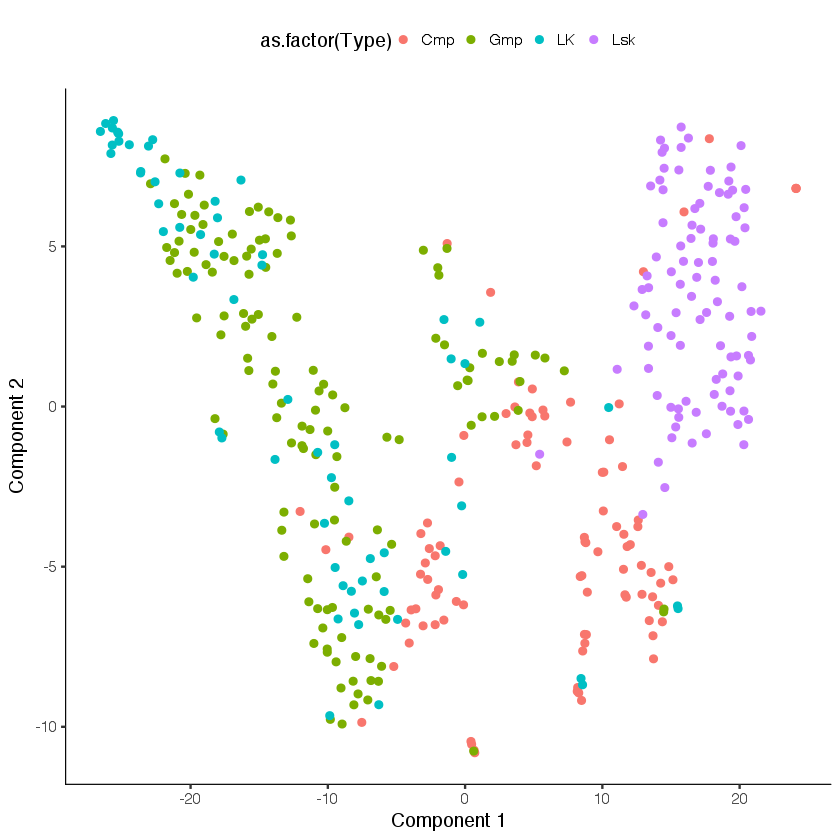

In [4]:
#1. set ordering genes for the fig1b
URMM_all_fig1b <- setOrderingFilter(URMM_all_fig1b, ordering_genes = row.names(fig1b))
URMM_pc_variance <- plot_pc_variance_explained(URMM_all_fig1b, return_all = T, norm_method = 'log')

#2. run reduceDimension with tSNE as the reduction_method
set.seed(2017)
URMM_all_fig1b <- reduceDimension(URMM_all_fig1b, max_components=2, norm_method = 'log', reduction_method = 'tSNE', num_dim = 12,  verbose = F)

#3. initial run of clusterCells
URMM_all_fig1b <- clusterCells(URMM_all_fig1b, verbose = F, num_clusters = 5)

# plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(cluster)', show_density_peak = T, show_density = T) # show_density = F,

#4. check the clusters
plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(Cluster)') # show_density = F,
plot_cell_clusters(URMM_all_fig1b, color_by = 'cluster')
plot_cell_clusters(URMM_all_fig1b, color_by = 'Cluster') + facet_wrap(~cluster) #, show_density = F
plot_cell_clusters(URMM_all_fig1b, color_by = 'Type') #, show_density = F
# # plot_cell_clusters(URMM_all_fig1b, color_by = 'State', show_density = F) + scale_color_brewer(palette = 'Set1') + facet_wrap(~paper_cluster)
# # plot_cell_clusters(URMM_all_fig1b, color_by = 'Cluster', show_density = F) + scale_color_brewer(palette = 'Set1') + facet_wrap(~paper_cluster)
#
# #5. also check the decision plot
plot_rho_delta(URMM_all_fig1b) #, rho_threshold = 6, delta_threshold = 7)
#
# #6. re-run cluster and skipping calculating the rho_sigma
#URMM_all_fig1b <- clusterCells(URMM_all_fig1b, verbose = F,  rho_threshold = 6, delta_threshold = 7, skip_rho_sigma = T)
# # URMM_all_fig1b <- clusterCells(URMM_all_fig1b, verbose = F,  num_clusters = 4)

#7. make the final clustering plot:
plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(Cluster)') #, rho_threshold = 6, delta_threshold = 2, show_density = F
plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(cluster)') #, rho_threshold = 6, delta_threshold = 2, show_density = F
plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(Type)') #, rho_threshold = 6, delta_threshold = 2, show_density = F

#perform DEG test across clusters:
URMM_all_fig1b@expressionFamily <- negbinomial.size()
pData(URMM_all_fig1b)$Cluster <- factor(pData(URMM_all_fig1b)$Cluster)
URMM_clustering_DEG_genes <- differentialGeneTest(URMM_all_fig1b, fullModelFormulaStr = '~Cluster', cores = detectCores() - 2)

#use all DEG gene from the clusters
URMM_ordering_genes <- row.names(URMM_clustering_DEG_genes)[order(URMM_clustering_DEG_genes$qval)][1:1000]

# reconstruct the developmental trajectory for the wild-type data 

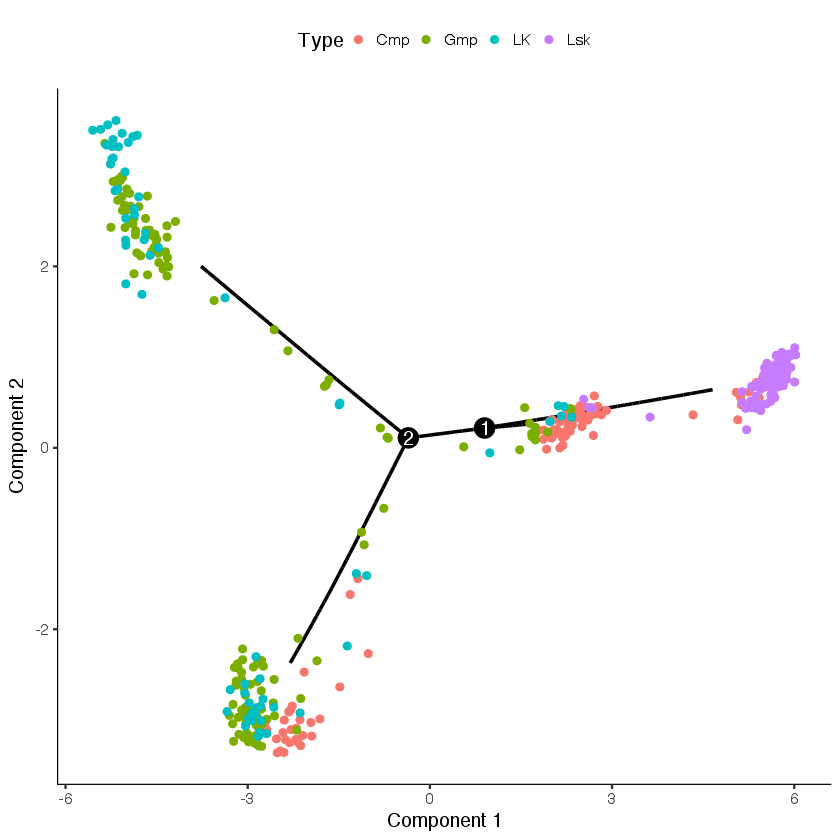

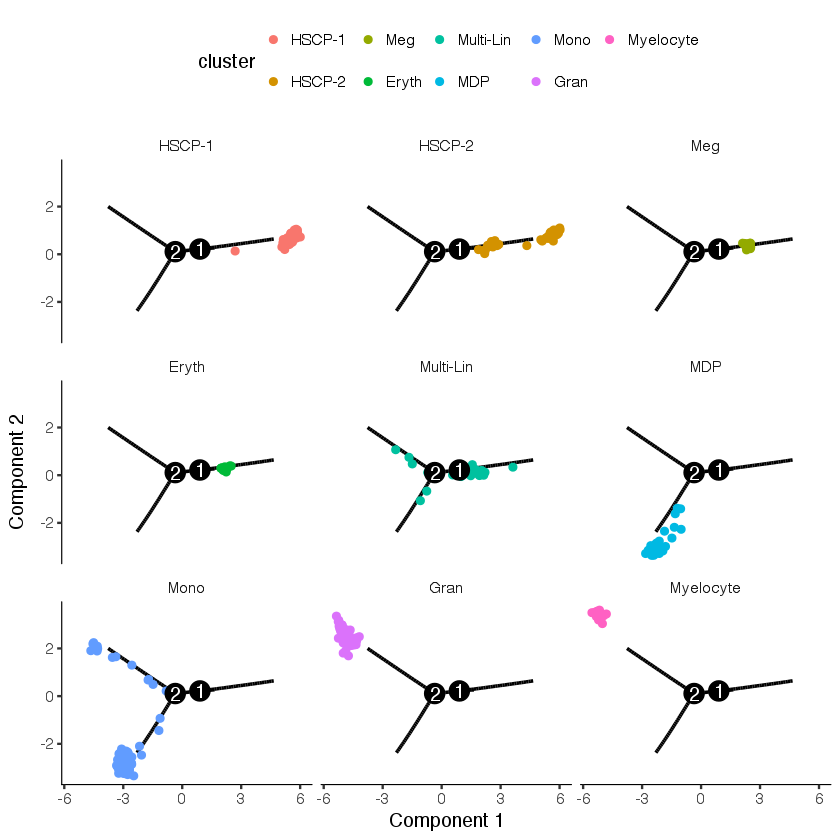

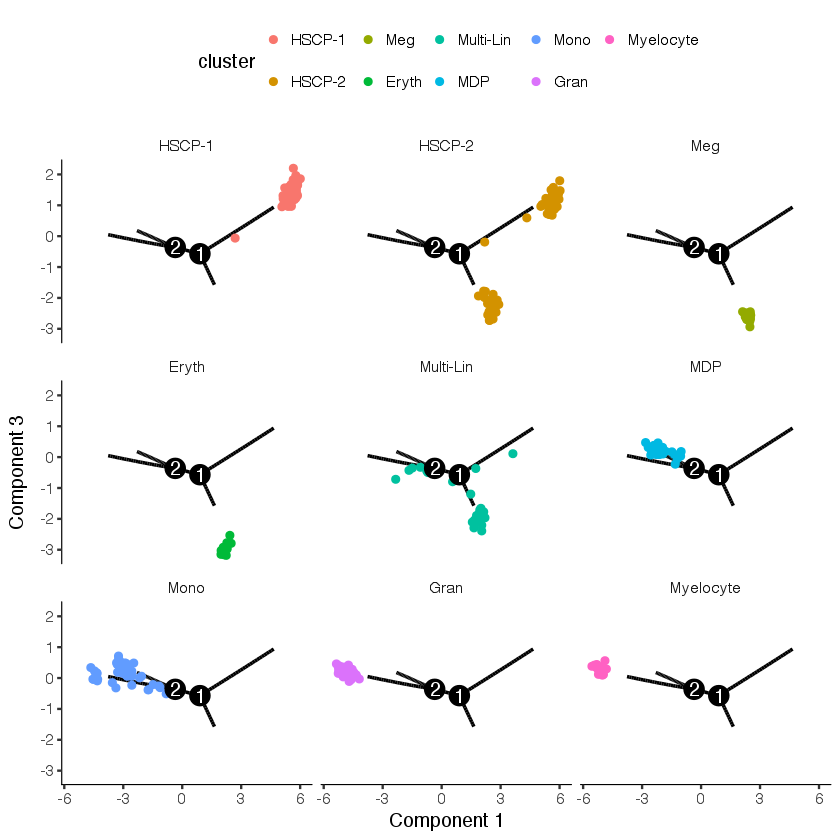

In [5]:
URMM_all_fig1b <- setOrderingFilter(URMM_all_fig1b, ordering_genes = c(URMM_ordering_genes))
URMM_all_fig1b <- reduceDimension(URMM_all_fig1b, verbose = F, scaling = T, max_components = 4, maxIter = 100, norm_method = 'log',  lambda = 20 * ncol(URMM_all_fig1b)) #, maxIter = 100, initial_method = DM, R_tSNE, tSNE, destiny_diffusionMaps, maxIter = 100 , param.gamma = 100, ncenter = 100
URMM_all_fig1b <- orderCells(URMM_all_fig1b)
plot_cell_trajectory(URMM_all_fig1b, color_by = 'Type')
plot_cell_trajectory(URMM_all_fig1b, color_by = 'cluster') + facet_wrap(~cluster)
plot_cell_trajectory(URMM_all_fig1b, color_by = 'cluster', x = 1, y = 3) + facet_wrap(~cluster)


# reconstruct the developmental trajectory for all cells using the same set of genes

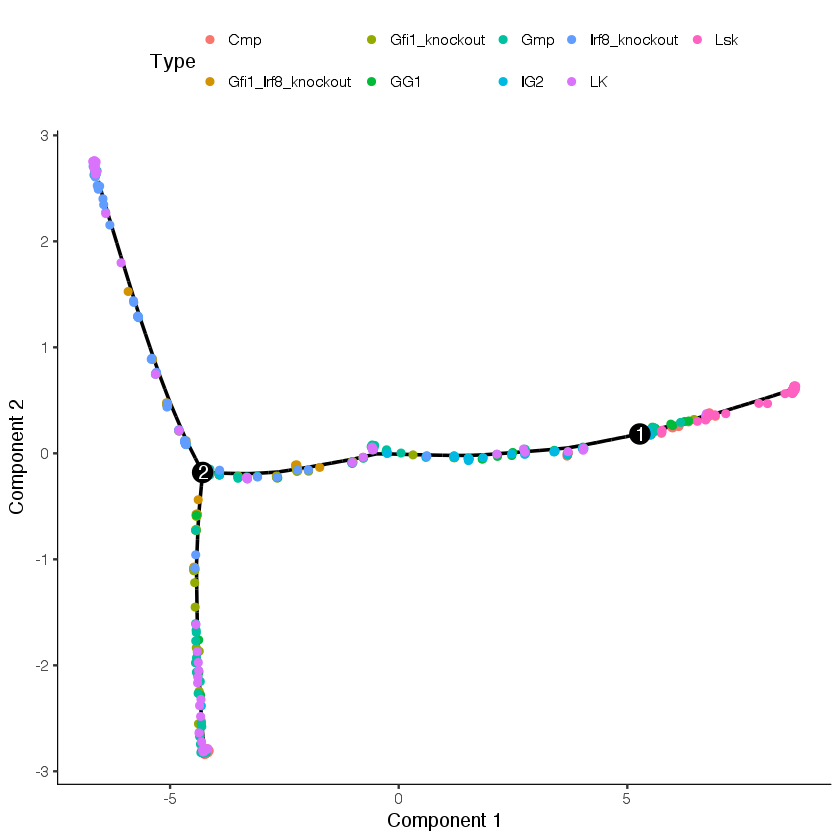

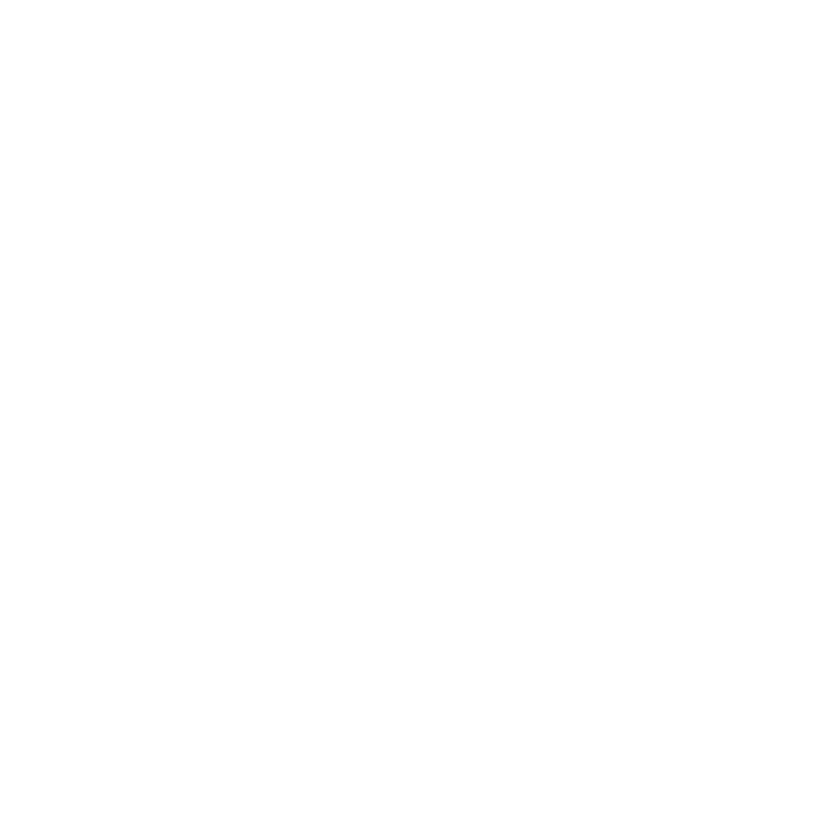

In [6]:
URMM_all_abs <- setOrderingFilter(URMM_all_abs, ordering_genes = URMM_ordering_genes)
URMM_all_abs <- reduceDimension(URMM_all_abs, verbose = F, scaling = T, maxIter = 100, norm_method = 'log', max_components = 4, param.gamma = 100, lambda = 14 * ncol(URMM_all_fig1b)) # norm_method = 'log',, param.gamma = 100
URMM_all_abs <- orderCells(URMM_all_abs)
plot_cell_trajectory(URMM_all_abs, color_by = 'Type')
plot_cell_trajectory(URMM_all_abs, color_by = 'Type') + facet_wrap(~paper_cluster)

# show the complicate tree structure for WT and full dataset

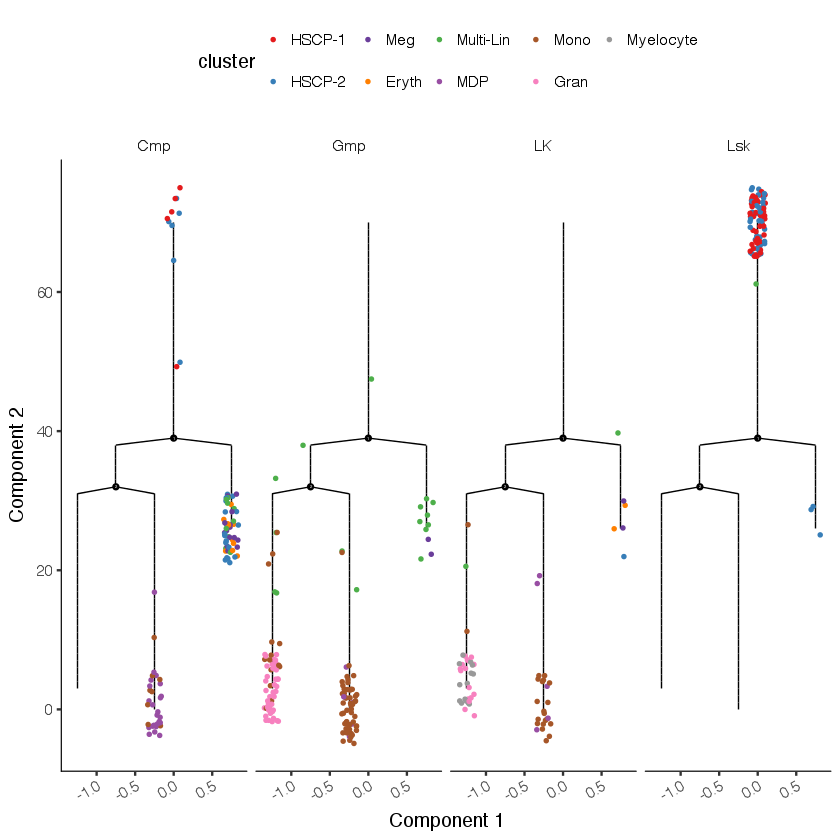

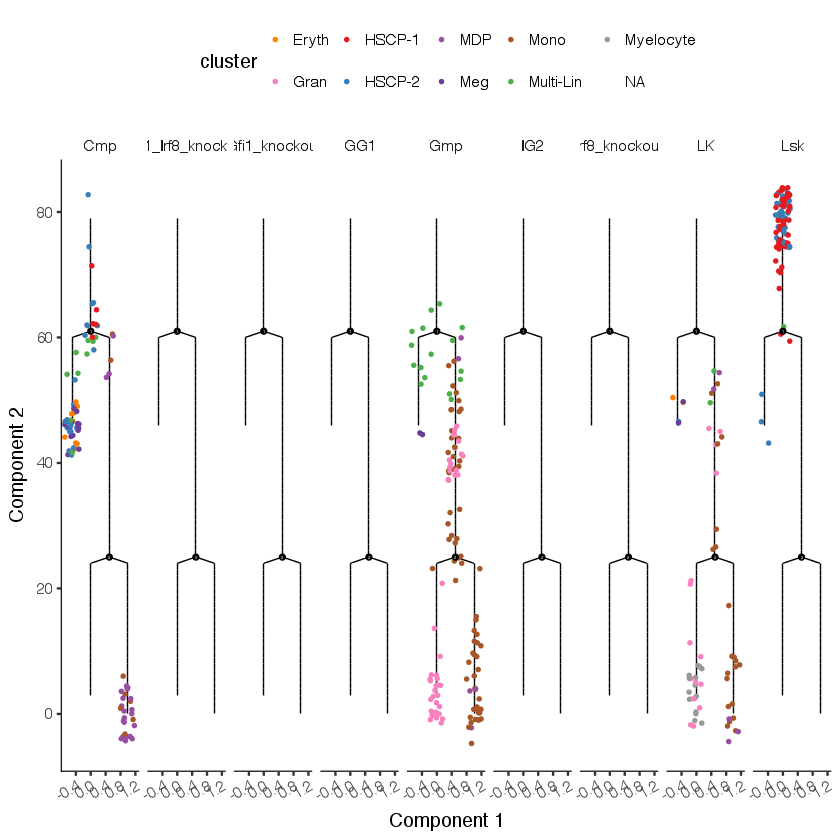

In [7]:
type_vec <- unique(pData(URMM_all_abs)$Type)
type_cols <- RColorBrewer::brewer.pal(9, name = 'Set1')
type_cols[6] <- "#6A3D9A"
names(type_cols) <- type_vec
 
cluster_vec <- unique(pData(URMM_all_fig1b)$cluster)
cluster_cols <- type_cols
cluster_cols[10] <- "#0600FC"
names(cluster_cols) <- cluster_vec

plot_complex_cell_trajectory(URMM_all_fig1b[, ], color_by = 'cluster', show_branch_points = T, cell_size = 0.5, cell_link_size = 0.3) + facet_wrap(~Type, nrow = 1) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = cluster_cols, name = "cluster")

pData(URMM_all_abs)$paper_cluster <- NA
pData(URMM_all_abs)[colnames(URMM_all_fig1b), 'paper_cluster'] <- as.character(pData(URMM_all_fig1b)[, 'cluster'])
plot_complex_cell_trajectory(URMM_all_abs[, ], color_by = 'paper_cluster', show_branch_points = T, cell_size = 0.5, cell_link_size = 0.3) + facet_wrap(~Type, nrow = 1) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = cluster_cols, name = "cluster") 